In [1]:
# coding: utf-8
import numpy as np


def load_data(seed=1984):
    np.random.seed(seed)
    N = 100  # 클래스당 샘플 수
    DIM = 2  # 데어터 요소 수
    CLS_NUM = 3  # 클래스 수

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=int)

    for j in range(CLS_NUM):
        for i in range(N): # N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

In [2]:
x,t=load_data()

In [3]:
print('x',x.shape)
print('t',t.shape)

x (300, 2)
t (300, 3)


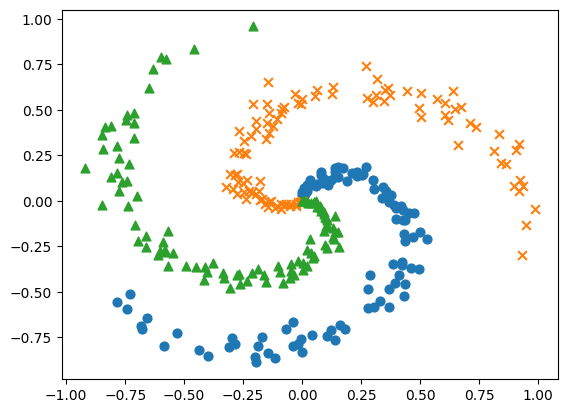

In [5]:
import matplotlib.pyplot as plt 
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

In [6]:
class Sigmoid:
    def __init__(self):
        self.params,self.grads = [],[]
        self.out = None
        
    def forward(self,x):
        out = 1 / (1+np.exp(-x))
        self.out=out
        return out 
    
    def backward(self,dout):
        dx = dout * (1.0- self.out) *self.out
        return dx 


In [7]:
class Affine:
    def __init__(self,W,b):
        self.params = [W,b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self,x):
        W,b=self.params
        out = np.matmul(x,W) + b
        self.x = x 
        return out 
    
    def backward(self,dout):
        W,b=self.params
        dx = np.matmul(dout,W.T)
        dW = np.matmul(self.x.T , dout)
        db = np.sum(dout , axis=0)
        
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx 

In [8]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # 오버플로우 방지를 위한 조치
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_error(y, t):
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


신경망 구현

In [9]:
import numpy as np 
class TwoLayerNet:
    def __init__(self,input_size,hidden_size,output_size):
        I,H,O = input_size,hidden_size,output_size
        
        #가중치와 편향 초기화 
        W1 = 0.01*np.random.randn(I,H)
        b1=np.zeros(H)
        W2 = 0.01*np.random.randn(H,O)
        b2=np.zeros(O)
        
        #계층생성
        self.layers = [
            Affine(W1,b1),
            Sigmoid(),
            Affine(W2,b2)
        ]
        
        self.loss_layer = SoftmaxWithLoss()
        
        self.params,self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads 
        
    def predict(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self,x,t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score,t)
        return loss 

    def backward(self,dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        
        return dout
        
        

학습용 코드 

In [10]:
class SGD:
    '''
    확률적 경사하강법(Stochastic Gradient Descent)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

In [15]:
#1 하이퍼 파라미터 설정
max_epoch = 300 
batch_size =30
hidden_size =10
learning_rate=1.0
#2 데이터 읽기 , 모델과 옵티마이저 생성
x,t=load_data()
model = TwoLayerNet(input_size=2,hidden_size=hidden_size,output_size=3)
optimizer=SGD(lr=learning_rate)
# 학습에 사용하는 변수 
data_size = len(x)
max_iters = data_size // batch_size 
total_loss =0 
loss_count = 0 
loss_list = []

#3 데이터 뒤썩기 
for epoch in range(max_epoch):
    idx = np.random.permutation(data_size)
    x=x[idx]
    t=t[idx]
    
    for iters in range(max_iters): 
        batch_x=x[iters*batch_size:(iters+1)*batch_size]
        batch_t=t[iters*batch_size:(iters+1)*batch_size]      
        
    #4 기울기를 구해 매개변수 갱신 
    loss = model.forward(batch_x,batch_t)
    model.backward()
    optimizer.update(model.params,model.grads)

    total_loss += loss  
    loss_count += 1 

    #5 정기적으로 학습 결과 출력 
    if (iters+1) % 10 ==0:
        avg_loss = total_loss / loss_count
        print('|에폭 %d| 반복 %d / %d | 손실 %.2f'
          %(epoch+1,iters+1,max_iters,avg_loss))
        loss_list.append(avg_loss)
        total_loss , loss_count =0,0



       



|에폭 1| 반복 10 / 10 | 손실 1.10
|에폭 2| 반복 10 / 10 | 손실 1.12
|에폭 3| 반복 10 / 10 | 손실 1.10
|에폭 4| 반복 10 / 10 | 손실 1.08
|에폭 5| 반복 10 / 10 | 손실 1.18
|에폭 6| 반복 10 / 10 | 손실 1.22
|에폭 7| 반복 10 / 10 | 손실 1.24
|에폭 8| 반복 10 / 10 | 손실 1.13
|에폭 9| 반복 10 / 10 | 손실 1.12
|에폭 10| 반복 10 / 10 | 손실 1.20
|에폭 11| 반복 10 / 10 | 손실 1.22
|에폭 12| 반복 10 / 10 | 손실 1.22
|에폭 13| 반복 10 / 10 | 손실 1.10
|에폭 14| 반복 10 / 10 | 손실 1.12
|에폭 15| 반복 10 / 10 | 손실 1.24
|에폭 16| 반복 10 / 10 | 손실 1.32
|에폭 17| 반복 10 / 10 | 손실 1.16
|에폭 18| 반복 10 / 10 | 손실 1.10
|에폭 19| 반복 10 / 10 | 손실 1.13
|에폭 20| 반복 10 / 10 | 손실 1.12
|에폭 21| 반복 10 / 10 | 손실 1.06
|에폭 22| 반복 10 / 10 | 손실 1.42
|에폭 23| 반복 10 / 10 | 손실 1.11
|에폭 24| 반복 10 / 10 | 손실 1.17
|에폭 25| 반복 10 / 10 | 손실 1.06
|에폭 26| 반복 10 / 10 | 손실 1.24
|에폭 27| 반복 10 / 10 | 손실 1.11
|에폭 28| 반복 10 / 10 | 손실 1.11
|에폭 29| 반복 10 / 10 | 손실 1.11
|에폭 30| 반복 10 / 10 | 손실 1.13
|에폭 31| 반복 10 / 10 | 손실 1.13
|에폭 32| 반복 10 / 10 | 손실 1.24
|에폭 33| 반복 10 / 10 | 손실 1.20
|에폭 34| 반복 10 / 10 | 손실 1.08
|에폭 35| 반복 10 / 10 | 손실

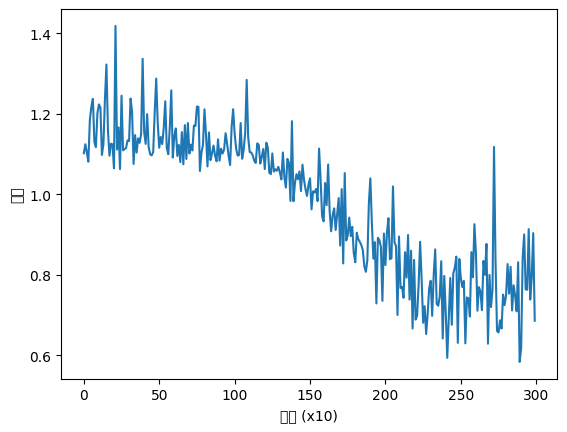

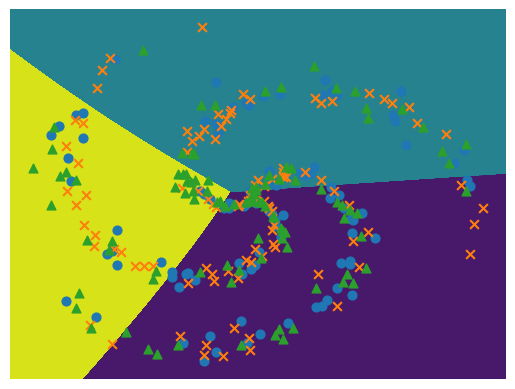

In [16]:
# 학습 결과 플롯
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('반복 (x10)')
plt.ylabel('손실')
plt.show()

# 경계 영역 플롯
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# 데이터점 플롯
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()